<a href="https://colab.research.google.com/github/giuseppesalvi/MLinA-CRC-Contest-Assignment/blob/main/MLinA_CRC_Contest_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Mount drive

In [322]:
# Professor's results
# 50 epochs - 60% accuracy - 80% after selective classification

In [323]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Import code from repository

In [324]:
#!rm -r "/content/drive/MyDrive/Teaching&Thesis/Teaching_dataset/teaching-MLinAPP"
#!git clone https://github.com/frpnz/teaching-MLinAPP.git "/content/drive/MyDrive/Teaching&Thesis/Teaching_dataset/teaching-MLinAPP"

# Clone dataset repository and load data

In [325]:
!rm -r "/content/patch_dataset_noisy"
!git clone https://github.com/frpnz/dataset-BIOSTEC2018-noisy.git "/content/patch_dataset_noisy"

import zipfile
import numpy as np
from PIL import Image
filepath = "/content/patch_dataset_noisy/crc_3_noisy.zip"
with zipfile.ZipFile(filepath, 'r') as zip_ref:
    zip_ref.extractall("/content/patch_dataset_noisy")
X_test_noisy = np.load("/content/patch_dataset_noisy/crc_3_noisy/X_test.npy")
Y_test_noisy = np.load("/content/patch_dataset_noisy/crc_3_noisy/Y_test.npy")
X_train_noisy = np.load("/content/patch_dataset_noisy/crc_3_noisy/X_train.npy")
Y_train_noisy = np.load("/content/patch_dataset_noisy/crc_3_noisy/Y_train.npy")
x_mean_train = np.load("/content/patch_dataset_noisy/crc_3_noisy/mean_x_train.npy")

# Undo preprocessing to plot images
X_train_noisy = X_train_noisy*255 + x_mean_train
X_train_noisy = X_train_noisy.astype(np.uint8)
# Shuffle data
indexes = np.arange(len(X_train_noisy))
np.random.shuffle(indexes)
X_train_noisy = X_train_noisy[indexes]
Y_train_noisy = Y_train_noisy[indexes]
# Undo preprocessing to plot images
X_test_noisy = X_test_noisy*255 + x_mean_train
X_test_noisy = X_test_noisy.astype(np.uint8)
# Shuffle data
indexes = np.arange(len(X_test_noisy))
np.random.shuffle(indexes)
X_test_noisy = X_test_noisy[indexes]
Y_test_noisy = Y_test_noisy[indexes]

rm: cannot remove '/content/patch_dataset_noisy': No such file or directory
Cloning into '/content/patch_dataset_noisy'...
remote: Enumerating objects: 4, done.
remote: Total 4 (delta 0), reused 0 (delta 0), pack-reused 4
Unpacking objects: 100% (4/4), done.


In [326]:
import os
import sys
import pickle
import numpy as np
import pandas as pd
from glob import glob
import tensorflow as tf
# os.environ["CUDA_VISIBLE_DEVICES"] = '0'
# os.environ["TF_FORCE_GPU_ALLOW_GROWTH"] = 'true'
import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn.metrics import confusion_matrix
ROOTDIR_DATA = "/content/drive/MyDrive/Datasets/Teaching_dataset/"
ROOTDIR_SRC = "/content/drive/MyDrive/Datasets/Teaching_dataset/teaching-MLinAPP/src"
ROOTDIR_OUTPUT = "/content/models"
plt.style.use(os.path.join(ROOTDIR_SRC, "mystyle.mplstyle"))
import sys
sys.path.append(ROOTDIR_SRC)
#from resnet import ResNet
import matplotlib.pyplot as plt

In [327]:
tile_new_size = 64
epochs = 50 
learning_rate = 1e-3 
batch_size = 128 

AUGMENTATION = True

# Resize to tile_new_size
X_test_noisy = np.array([np.array(Image.fromarray(x).resize((tile_new_size, tile_new_size), Image.ANTIALIAS)) for x in X_test_noisy])
X_train_noisy = np.array([np.array(Image.fromarray(x).resize((tile_new_size, tile_new_size), Image.ANTIALIAS)) for x in X_train_noisy])

In [328]:
X_test_noisy.shape

(7308, 64, 64, 3)

In [329]:
X_train_noisy.shape

(12336, 64, 64, 3)

## Prepare tf dataset

In [330]:
train_ds = tf.data.Dataset.from_tensor_slices((X_train_noisy, Y_train_noisy))
test_ds = tf.data.Dataset.from_tensor_slices((X_test_noisy, Y_test_noisy))

## Show some images with correspondig label as title

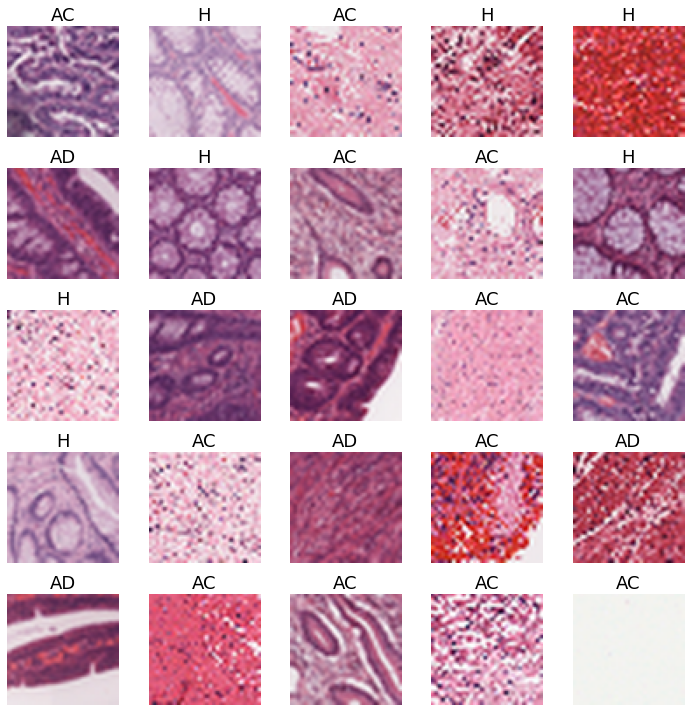

In [331]:
number2title_dict = {
    0: "AC",
    1: "AD",
    2: "H"
}

fig, ax = plt.subplots(5, 5, figsize=(10, 10))
ax = ax.ravel()
j = 0
for X, Y in test_ds.take(25):
    ax[j].imshow(X.numpy().astype("uint8"))
    ax[j].set_title(number2title_dict[Y.numpy()])
    ax[j].axis("off")
    j += 1
plt.tight_layout()

## Prepare tf dataset pipeline

In [332]:
def process_data(image, label):
    return tf.cast(image, tf.float32)/255., tf.one_hot(label, 3, name='label', axis=-1)

In [333]:
train_ds = train_ds.map(process_data, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.cache()
# TODO: shuffle?
y_true_train_ds = np.array([y.numpy() for x, y in train_ds])
train_ds = train_ds.batch(128)
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)

test_ds = test_ds.map(process_data, num_parallel_calls=tf.data.AUTOTUNE)
test_ds = test_ds.cache()
y_true_test_ds = np.array([y.numpy() for x, y in test_ds])
test_ds = test_ds.batch(128)
test_ds = test_ds.prefetch(tf.data.AUTOTUNE)


# CNN definition and training
You must implement:


1.   An augmentation block
2.   Three callbacks: 

           A) tf.keras.callbacks.ModelCheckpoint
           B) tf.keras.callbacks.EarlyStopping
           C) tf.keras.callbacks.ReduceLROnPlateau


### Data Augmentation

In [334]:
# Random Crop
policy_random_crop = tf.keras.Sequential([
      tf.keras.layers.RandomCrop(48, 48),
      tf.keras.layers.Resizing(64, 64)])

# Flip
policy_random_flip = tf.keras.Sequential([
      tf.keras.layers.RandomFlip("horizontal_and_vertical")])

# Change Contrast
policy_random_contrast = tf.keras.Sequential([
      tf.keras.layers.RandomContrast(0.3, 0.3)])

# Zoom
policy_random_zoom = tf.keras.Sequential([
      tf.keras.layers.RandomZoom(0.3)])


augmentation_block = [
  policy_random_crop,
  policy_random_flip,
  policy_random_contrast,
  policy_random_zoom,
]

# Augmentation in traning dataset
if AUGMENTATION:
    for augmentation in augmentation_block:
            train_ds = train_ds.map(lambda x, y: (augmentation(x, training=False), y))

### Callbacks

In [335]:
checkpoint_filepath = os.path.join(ROOTDIR_OUTPUT, '/content/checkpoint1')

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='accuracy',
    mode='max',
    save_best_only=True)


early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='accuracy', 
    patience=10)

reduce_lr_on_plateau_callback = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='accuracy', 
    factor=0.2, 
    patience=5, 
    min_lr=0.001,
    mode='auto')

callbacks = [model_checkpoint_callback, 
             early_stopping_callback, 
             reduce_lr_on_plateau_callback]

### Model

#### Resnet18 

In [336]:
class Residual(tf.keras.Model):
    """The Residual block of ResNet."""
    def __init__(self, num_channels, use_1x1conv=False, strides=1):
        super().__init__()
        self.conv1 = tf.keras.layers.Conv2D(
            num_channels, 
            padding='same', 
            kernel_size=3, 
            strides=strides)
        self.conv2 = tf.keras.layers.Conv2D(
            num_channels, 
            kernel_size=3, 
            padding='same')
        self.conv_1x1 = None
        if use_1x1conv:
            self.conv_1x1 = tf.keras.layers.Conv2D(
                num_channels, 
                kernel_size=1, 
                strides=strides)
        self.bn1 = tf.keras.layers.BatchNormalization()
        self.bn2 = tf.keras.layers.BatchNormalization()

    def call(self, X):

        # Y = F(X) + X

        # first layer
        Y = self.conv1(X)
        Y = self.bn1(Y)
        Y = tf.keras.activations.relu(Y)
        
        # second layer
        Y = self.conv2(Y)
        Y = self.bn2(Y)

        # if input has the same dimension as the output the block implements an
        # identity function, otherwise we insert a 1x1 convolutional block
        if self.conv_1x1 is not None:
            X = self.conv_1x1(X)

        # Add Residual
        Y += X 
        return tf.keras.activations.relu(Y)

In [337]:
class ResnetBlock(tf.keras.layers.Layer):
    def __init__(self, num_channels, num_residuals, downscale=True,
                 **kwargs):
        super(ResnetBlock, self).__init__(**kwargs)
        self.residual_layers = []
        for i in range(num_residuals):
            if i == 0 and downscale:
                self.residual_layers.append(
                    Residual(num_channels, use_1x1conv=True, strides=2))
            else:
                self.residual_layers.append(Residual(num_channels))

    def call(self, X):
        for layer in self.residual_layers.layers:
            X = layer(X)
        return X

In [338]:
class ResNet(tf.keras.Model):

    def __init__(self, num_classes=3):
        super(ResNet, self).__init__()
        self.block_a = tf.keras.Sequential(
            [tf.keras.layers.Conv2D(64, 
                                    kernel_size=7, 
                                    strides=2, 
                                    padding='same'),
             tf.keras.layers.BatchNormalization(),
             tf.keras.layers.MaxPool2D(pool_size=3, 
                                       strides=2, 
                                       padding='same')])             
        self.block_b = ResnetBlock(64, 2, downscale=False)
        self.block_c = ResnetBlock(128, 2)
        self.block_d = ResnetBlock(256, 2)
        self.block_e = ResnetBlock(512, 2)
        self.global_pool = tf.keras.layers.GlobalAveragePooling2D()
        self.classifier = tf.keras.layers.Dense(
            num_classes, 
            activation="softmax")

    def call(self, inputs):
        x = inputs
        x = self.block_a(x)
        x = self.block_b(x)
        x = self.block_c(x)
        x = self.block_d(x)
        x = self.block_e(x)
        x = self.global_pool(x)
        return self.classifier(x)

#### Train

In [339]:
TRAINMODEL = False
if TRAINMODEL:
  model = ResNet()
  model.build((1, 64, 64, 3))
  model.summary()

  optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
  loss = tf.keras.losses.categorical_crossentropy
  model.compile(optimizer=optimizer, loss=loss, metrics="accuracy")
  model.fit(train_ds, epochs=epochs, callbacks=callbacks)

In [340]:
# Copy checkpoint to drive
#!cp -r ./checkpoint1 drive/MyDrive/Datasets/

# Copy checkpoint from drive
#!cp -r drive/MyDrive/Datsets/checkpoint .

In [341]:
# Load model from checkpoint
model = tf.keras.models.load_model(checkpoint_filepath)

## Test the model
Plot a confusion matrix

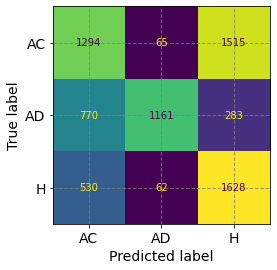

Accuracy: 0.57


In [342]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_predicted = np.argmax(model.predict(test_ds, batch_size=batch_size), axis=1)
y_labels = np.argmax(y_true_test_ds, axis=1)
conf_matrix = confusion_matrix(y_labels, y_predicted)

ConfusionMatrixDisplay.from_predictions(y_labels, y_predicted, display_labels=["AC","AD","H"], colorbar=False)
# ConfusionMatrixDisplay.from_predictions(y_labels, y_predicted, display_labels=["AC","AD","H"], colorbar=False, normalize="true")

plt.show()

accuracy = np.mean(np.diag(conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]))
print("Accuracy: {:.2f}".format(accuracy))

# Selective classification applied to histological images

### TTA Wrapper

In [343]:
class TTAWrapper:
    def __init__(self, keras_model, input_shape=(64, 64, 3)):
        super(TTAWrapper, self).__init__()
        self.model = keras_model
        self._input_shape = input_shape
        self._uncertainty_metrics = dict()
        self._uncertainty_metrics['entropy'] = self._entropy
        self._uncertainty_metrics['variance'] = self._variance
        self._uncertainty_metrics['max_softmax_response'] = self._max_softmax_response

    def uncertainty_metrics(self, multiple_preds):
        return {metric: self._compute_uncertainty(metric, multiple_preds) for metric in self._uncertainty_metrics.keys()}
    
    def _normalize(self, values):
        # normalize the output throught 0 and 1
        return (values - values.min()) / (values.max() - values.min())

    def _compute_uncertainty(self, metric, multiple_preds):
        try:
            print("Done {}".format(metric))
            return self._normalize(self._uncertainty_metrics[metric](multiple_preds))
        except KeyError:
            print("{} not implemented.".format(metric))

    def predict_many_times(self, inputs, draws=2):
        # make n=draws predictions, and return the result in a np array
        return np.array([self.predict(inputs) for _ in range(draws)])

    def _average_prediction(self, multiple_preds):
        # to compute the average prediction, calculate the mean on the first 
        # columnt (axis=0), so on the same sample over different predictions 
        if len(multiple_preds.shape) > 2:
            return np.mean(np.array(multiple_preds), axis=0)
        else:
          return multiple_preds

    def _variance(self, multiple_preds):
        # note: if the output of the network is sure, the variance will be higher
        # for example the softmax for class a is always high and for class c and
        # b is always low
        avg_preds = self._average_prediction(multiple_preds)
        return np.var(avg_preds, axis=1)

    def _max_softmax_response(self, multiple_preds):
        avg_preds = self._average_prediction(multiple_preds)
        return np.max(avg_preds, axis=1)

    def _entropy(self, multiple_preds):
        avg_preds = self._average_prediction(multiple_preds)
        eps = 1e-5
        return -1 * np.sum(avg_preds * np.log(avg_preds + eps), axis=1)

    def predict_many_times(self, ds, policy, draws=1):
        pred_augmented = list()

        # Different kinds of data augmentations
        # Random Crop
        policy_random_crop = [
            tf.keras.Sequential([
                tf.keras.layers.RandomCrop(int(self._input_shape[0] - 0.1*self._input_shape[0]),
                                           int(self._input_shape[0] - 0.1*self._input_shape[0])),
                tf.keras.layers.Resizing(self._input_shape[0],
                                         self._input_shape[1])])]
        # Flip
        policy_random_flip = [
            tf.keras.Sequential([
                tf.keras.layers.RandomFlip("horizontal_and_vertical")])
        ]

        # Change Contrast
        policy_random_contrast = [
            tf.keras.Sequential([
                tf.keras.layers.RandomContrast(0.3, 0.3)])
        ]

        # Zoom
        policy_random_zoom = [
            tf.keras.Sequential([
              tf.keras.layers.RandomZoom(0.3)])
        ]

        policy_identity = [tf.keras.Sequential([
            tf.keras.layers.Layer()])]

        policies = dict()
        policies['identity'] = policy_identity
        policies['random_crop'] = policy_random_crop
        policies['random_contrast'] = policy_random_contrast
        policies['random_zoom'] = policy_random_zoom
        policies['random_flip'] = policy_random_flip
        policies['all'] = sum([policy_random_crop, policy_random_contrast, policy_random_zoom, policy_random_flip], [])

        policies['random_crop'] = sum([policies['random_crop'] for _ in range(draws)], [])
        policies['random_contrast'] = sum([policies['random_contrast'] for _ in range(draws)], [])
        policies['random_zoom'] = sum([policies['random_zoom'] for _ in range(draws)], [])
        policies['random_flip'] = sum([policies['random_flip'] for _ in range(draws)], [])
        policies['all'] = sum([policies['all'] for _ in range(draws)], [])

        for p in policies[policy]:
            ds_augmented = ds.map(lambda x, y: (p(x, training=True), y))
            pred_augmented.append(self.model.predict(ds_augmented))

        return pred_augmented


### Wrap model inside TTA Wrapper and do predictions

In [344]:
tta_model = TTAWrapper(model)

In [345]:
y_test_predicted = tta_model.predict_many_times(test_ds, "all", draws=5)

In [346]:
test_uncertainties = dict()
test_uncertainties['crc'] = (tta_model.uncertainty_metrics(np.array(y_test_predicted)), 
                        y_test_predicted, y_true_test_ds)

Done entropy
Done variance
Done max_softmax_response


### Find Theta

In [347]:
import scipy.stats
def get_risk_bound(n, r_emp, alpha=0.01):
    # n = number of the inliers
    # alpha is the confidence measure
    
    # Try different values for p, possible true risks
    p_array = np.linspace(0, 1, 100)
    # We calculate for each value of p, the cumulativie density function of a 
    # binomial with parameters p, n, nRemp 
    probabilities = np.array(
        [scipy.stats.binom.cdf(r_emp*n, n, p) for p in p_array])
    # Return the values of p that satisfy the inequation (1)
    return p_array[np.where(probabilities < alpha)][0]

In [348]:
def get_theta(y_pred, y_true, r, alpha, confidence_values):
    # y_pred is the array of predicted labels
    # y_true is the array of true labels
    # r is the acceptable true risk
    # confindence_values (k(x)) are the confidence values of the predictions

    # If y_pred and y_true have predictions for different classes, select the
    # prediction with the highest value
    if len(y_pred.shape) > 1:
        y_pred = np.argmax(y_pred, axis=1)
    if len(y_true.shape) > 1:
        y_true = np.argmax(y_true, axis=1)
    
    # Try different values of thetas, array of candidates theta
    thetas = np.array([_ for _ in np.linspace(0, 1, 10)])

    coverages = list()
    risk_bounds = list()

    for theta in thetas:
        try:
            # inliers are samples that we are confident enough to classify
            inliers = y_pred[confidence_values > theta]
            inliers_lables = y_true[confidence_values > theta]
            errors = sum(inliers != inliers_lables)
            risk = errors / len(inliers)

            # coverage depends on how many inliers we have
            coverages.append(len(inliers) / len(y_pred))
            risk_bounds.append(get_risk_bound(n=len(inliers), 
                                              r_emp=risk, 
                                              alpha=alpha))
        except ZeroDivisionError:
            coverages.append(0)
            risk_bounds.append(0)
    risk_bounds = np.array(risk_bounds)
    # filter depending on the empirical acceptable risk r
    indexes = risk_bounds == risk_bounds[risk_bounds <= r][0]
    if sum(indexes) > 1:
        first_true = np.where(indexes == True)[0][0]
        indexes = np.zeros(len(indexes), dtype=bool)
        indexes[first_true] = True
    return float(thetas[indexes]), float(np.array(coverages)[indexes]), float(risk_bounds[indexes]) 

In [349]:
risk = 0.2
y_train_predicted = np.array(tta_model.predict_many_times(train_ds, "all", draws=5)).mean(axis=0)
y_train_labels = np.argmax(y_true_train_ds, axis=1)


In [350]:
train_uncertainties = dict()
train_uncertainties['crc'] = ((tta_model.uncertainty_metrics(y_train_predicted), 
                        y_train_predicted, y_true_train_ds))

Done entropy
Done variance
Done max_softmax_response


In [351]:
(theta, coverage, risk_bound) = get_theta(y_train_labels,
                                          np.argmax(y_train_predicted, axis=1),
                                          risk, 
                                          0.01, 
                                          train_uncertainties['crc'][0]['variance'])

In [352]:
print("Theta : {:.2f}".format(theta))
print("Coverage : {:.2f}".format(coverage))
print("Risk Bound : {:.2f}".format(risk_bound))

Theta : 0.33
Coverage : 0.81
Risk Bound : 0.19


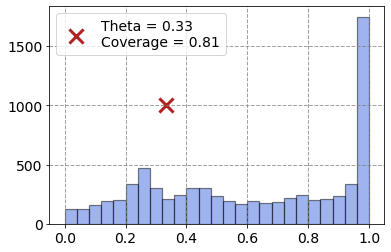

In [353]:
variance = test_uncertainties['crc'][0]['variance']
fig, ax = plt.subplots(1, 1)
ax.hist(variance,
        color="royalblue", 
        log=False, 
        bins=25, 
        edgecolor='black', 
        linewidth=1.2, 
        alpha=0.5);
ax.scatter(theta, 1000, 
           marker='x', 
           color="firebrick", 
           s=200, 
           linewidth=3,
           label="Theta = {:.2f}\nCoverage = {:.2f}".format(theta, coverage));
ax.legend();

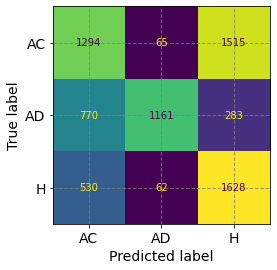

Accuracy: 0.62


In [354]:
y_test_labels_kept = y_true_test_ds[variance>theta].argmax(axis=1)
y_test_predicted_kept = np.array(y_test_predicted).mean(axis=0).argmax(axis=1)[variance>=theta]  

conf_matrix = confusion_matrix(y_test_labels_kept, y_test_predicted_kept)

ConfusionMatrixDisplay.from_predictions(y_labels, y_predicted, display_labels=["AC","AD","H"], colorbar=False)
#ConfusionMatrixDisplay.from_predictions(y_labels, y_predicted, display_labels=["AC","AD","H"], colorbar=False, normalize="true")

plt.show()

accuracy= np.mean(np.diag(conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]))
print("Accuracy: {:.2f}".format(accuracy))